# Adventure Works
## Análise Exploratória

[Rafael Gurgel](https://github.com/rurgel)

### Importação das bibliotecas necessárias

In [3]:
import pandas as pd
from pathlib import Path
from numpy import datetime64

import functions

### Declaração de constantes

In [6]:
DATAPATH = Path('input/AdventureWorks-oltp-install-script')

### Obtém a base de dados

O desafio solicita a análise utilizando a biblioteca Pandas.

Entretanto para analisar uma maior quantidade de dados e variáveis, buscou-se a fonte da base original, na Microsoft. Esses dados foram preparados para o uso em um banco SQL. Sendo assim, foi preciso criar um script adicional para carregar os dados no pandas.

Alternativamente, é possível criar uma infraestrutura de banco de dados, carregando um servidor no container e populando o banco de dados. Entretanto isso diverge do objetivo da análise exploratória dos dados. 

In [7]:
SalesOrderHeader = functions.get_table('SalesOrderHeader', DATAPATH)

### Avaliação da consistência da base de dados

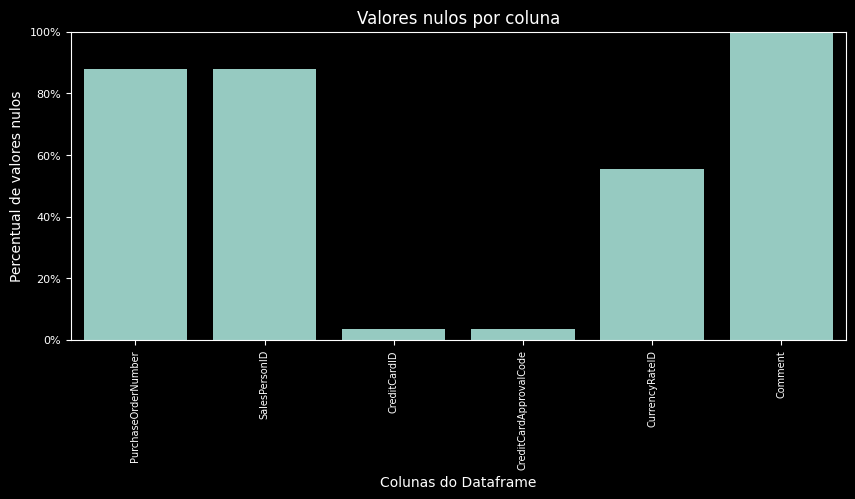

In [9]:
functions.plot_null(SalesOrderHeader, hue=None, filter=True)

Ajustando os tipos de dados. Ao converter o tipo da columna Comment para string, os valores nulos serão preenchidos pela string vazia.

In [13]:
SalesOrderHeader = SalesOrderHeader.astype({
    'SalesOrderID': int,
    'RevisionNumber': int,
    'OrderDate': 'datetime64[D]',
    'DueDate': 'datetime64[D]',
    'ShipDate': 'datetime64[D]',
    'Status': int,
    'OnlineOrderFlag': bool,
    'SalesOrderNumber': str,
    'PurchaseOrderNumber': object,
    'AccountNumber': str,
    'CustomerID': int,
    'SalesPersonID': 'Int64',
    'TerritoryID': int,
    'BillToAddressID': int,
    'ShipToAddressID': int,
    'ShipMethodID': int,
    'CreditCardID': 'Int64',
    'CreditCardApprovalCode': object,
    'CurrencyRateID': 'Int64',
    'SubTotal': float,
    'TaxAmt': float,
    'Freight': float,
    'TotalDue': float,
    'Comment': str,
    'rowguid': str,
    'ModifiedDate': 'datetime64[D]'
})

functions.summarize_dtypes(SalesOrderHeader)

Tipo dos Dados  Quantidade
         int64           8
        object           6
datetime64[ns]           4
       float64           4
         Int64           3
          bool           1


### Indicadores básicos

#### Portifólio de vendas

#### Lucro e Receitas

#### Produtos mais rentáveis

### Análise dos clientes

#### Tipos de clientes

##### Localização

##### Lucratividade total e média por tipo de cliente

##### Segmento mais requisitado por cada tipo de cliente

##### Forma de pagamento mais utilizada

### Insights Estratégicos

#### Relação do perfil demográfico com preferência por produtos vendidos, lucratividade média e total dos grupos, tendência a comprar durante promoções.

#### Influenciadores para compras

#### Efeito dos descontos (por transação e unidades)

#### Taxa de cambio

#### Sazonalidade (% de venda de um produto em relação ao total de vendas foi maior em algum período?)

#### Relação Tempo Médio de envio x Região x Quantidade de vendas